# CH03.3. **Transposed CNN**

## 00. **작업 환경 설정**

#### 00.0. **사전 변수 설정**

In [1]:
SEED_NUM = 2025
BATCH_SIZE = 32
EPOCH_NUM = 100
USE_CHECKPOINT_YN = 'N'
MODEL_PTH = '../../model/mnistAutoEncoder.pt'
LOGGER_PTH = '../../log/mnistTrainLogger.pt'

#### 00.1. **라이브러리 호출 및 옵션 설정**

In [2]:
#(1) Import libraries
import os
import ipywidgets
import random
import tqdm
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torchvision
import torchinfo

#(2) Set up options
os.environ['PYTHONHASHSEED'] = str(SEED_NUM)
random.seed(a=SEED_NUM)
np.random.seed(seed=SEED_NUM)
torch.use_deterministic_algorithms(mode=True)
torch.manual_seed(seed=SEED_NUM)
torch.mps.manual_seed(seed=SEED_NUM)

#(3) Set up device
if torch.backends.mps.is_available() :
    device = torch.device(device='mps')
else :
    device = torch.device(device='cpu')
print(f'>> Device : {device}')

#(4) Set up HTML tag
display(ipywidgets.HTML(data=
'''
<style> 
    .white-play button {
        background-color: white !important; 
        color: black !important;
    } 
</style>
'''
))

>> Device : mps


HTML(value='')

#### 00.2. **사용자정의함수 정의**

In [3]:
def show_img(df:torchvision.datasets, index:int) -> plt.figure :
    img = df[index][0]
    target = df[index][1]
    img = (img/2+0.5).numpy() # -1 ~ 1 normalization 
    channel_cnt = img.shape[0]
    if channel_cnt == 3 :
        img = np.transpose(a=img, axes=(1, 2, 0))
        plt.imshow(X=img) 
    elif channel_cnt == 1 : 
        img = np.squeeze(a=img, axis=0)
        plt.imshow(X=img, cmap='gray')
    else : 
        pass 
    plt.xlabel(xlabel=f'Target : {target}({df.classes[target]})')
    plt.show()

#### 00.3. **클래스 정의**

In [4]:
#(1) Define `Flatten` class
class Flatten(torch.nn.Module) :
    def forward(self, x:torch.Tensor) -> torch.Tensor :
        '''
            (batch size, channel size , (image) height, image width) -> (batch size, channel size * image width * image height) 
                                                                     -> (batch size, channel size * (image size)**2) 
        '''
        batch_size = x.shape[0]
        x = x.reshape(shape=(batch_size, -1))
        return x 

#(2) Define `Unflatten` class
class Unflatten(torch.nn.Module) :
    def __init__(self, channel_num:int) :
        super().__init__()
        self.channel_num = channel_num
    def forward(self, x:torch.Tensor) -> torch.Tensor :
        ''' 
            (batch size, channel size * (image) height * width) -> (batch size, channel size, height, width) 
        '''
        shape = x.shape
        img_size = int((shape[1]//self.channel_num)**0.5) 
        x = x.reshape(shape=(shape[0], self.channel_num, img_size, img_size))
        return  x 
    
#(3) Define `MyConvAutoEncoder` class
class MyConvAutoEncoder(torch.nn.Module) :
    def __init__(self, input_shape:list, channel_num:int, class_num:int, device:torch.device) :
        super().__init__()
        self.input_shape = input_shape
        self.channel_num = channel_num
        self.device = device
        flattened_size = self._compute_flatten_size()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=channel_num, kernel_size=3, stride=2), 
            torch.nn.ReLU(), 
            torch.nn.Conv2d(in_channels=channel_num, out_channels=2*channel_num, kernel_size=3, stride=2),
            torch.nn.ReLU(), 
            torch.nn.Conv2d(in_channels=2*channel_num, out_channels=4*channel_num, kernel_size=3, stride=1),
            torch.nn.ReLU(),
            Flatten(),
            torch.nn.Linear(in_features=flattened_size, out_features=class_num), 
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 1024),
            torch.nn.ReLU(),
            Unflatten(channel_num=4*channel_num),
            torch.nn.ConvTranspose2d(in_channels=4*channel_num, out_channels=2*channel_num, kernel_size=3, stride=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=2*channel_num, out_channels=channel_num, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=channel_num, out_channels=1, kernel_size=3, stride=2, output_padding=1)
        )
        self.to(device=device)
    def _compute_flatten_size(self) -> int :
        with torch.no_grad() :
            dummy_data = torch.zeros(size=(1, 1, self.input_shape[1], self.input_shape[2])).to(device=self.device)
            dummy_fn = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1, out_channels=self.channel_num, kernel_size=3, stride=2), 
                torch.nn.ReLU(), 
                torch.nn.Conv2d(in_channels=self.channel_num, out_channels=2*self.channel_num, kernel_size=3, stride=2),
                torch.nn.ReLU(), 
                torch.nn.Conv2d(in_channels=2*self.channel_num, out_channels=4*self.channel_num, kernel_size=3, stride=1),
                torch.nn.ReLU()
            ).to(device=device)
            output = dummy_fn(dummy_data)
        output = output.reshape(shape=(1, -1)).shape[1]
        return output
    def forward(self, x:torch.Tensor) -> torch.Tensor :
        x = x.to(device=device)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#(3) Define `TrainLogger` class
class TrainLogger : 
    def __init__(self) :
        self.train_log = {
            'epoch'  : [],
            'inputs' : [],
            'preds'  : []
        }
    def log(self, epoch:int, inputs:torch.Tensor, preds:torch.Tensor, path:str) :
        self.train_log['epoch'].append(epoch)
        self.train_log['inputs'].append(inputs)
        self.train_log['preds'].append(preds)
        torch.save(obj={'train_log':self.train_log}, f=path)
    def move_device(self, device:str) :
        for i in range(len(self.train_log['inputs'])) :
            if (device == 'cpu') :
                self.train_log['inputs'][i] = self.train_log['inputs'][i].detach().cpu().numpy()
                self.train_log['preds'][i] = self.train_log['preds'][i].detach().cpu().numpy()
            else :
                self.train_log['inputs'][i] = self.train_log['inputs'][i].to(device=device)
                self.train_log['preds'][i] = self.train_log['preds'][i].to(device=device)

#(4) Define `Visualizer` class
class Visualizer :    
    def __init__(self, train_log:dict, fig_size:tuple=(8, 8)) :
        self.train_log = train_log
        self.fig_size = fig_size
        self.epoch_min = min(self.train_log['epoch'])
        self.epoch_max = max(self.train_log['epoch'])
        self.epoch_num = len(train_log['epoch']) - 1
        self.sample_num = train_log['inputs'][0].shape[0] - 1
        self.widget_output = ipywidgets.Output(
            layout=ipywidgets.Layout(
                width='auto', 
                height='auto', 
                margin='0px', 
                padding='0px'
            )
        )
        self.epoch_play = ipywidgets.Play(
            min=self.epoch_min,
            max=self.epoch_max,
            step=1,
            value=0,
            interval=250,
            description='Epoch Play',
            disabled=False
        )
        self.epoch_play.add_class(className='white-play')
        self.epoch_slider = ipywidgets.IntSlider(
            min=self.epoch_min,
            max=self.epoch_max,
            step=1,
            value=0,
            description='Epoch',
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        self.sample_slider = ipywidgets.IntSlider(
            min=0,
            max=self.sample_num,
            step=1,
            value=0,
            description='Sample',
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        ipywidgets.jslink(attr1=(self.epoch_play, 'value'), attr2=(self.epoch_slider, 'value'))
        self.epoch_slider.observe(handler=self.on_epoch_change, names='value')
        self.sample_slider.observe(handler=self.on_sample_change, names='value')
        with self.widget_output:
            self.fig, (self.ax1, self.ax2) = plt.subplots(nrows=1, ncols=2, figsize=self.fig_size)
            try:
                self.fig.canvas.header_visible = False
                self.fig.canvas.toolbar_visible = False
            except:
                pass
            plt.show()
        self.update_view()
    def on_epoch_change(self, change:dict) :
        self.update_view()
    def on_sample_change(self, change:dict) :
        self.update_view()
    def update_view(self) :
        with self.widget_output:
            self.ax1.clear()
            self.ax2.clear()
            ep_value = self.epoch_slider.value
            ep_idx = self.train_log['epoch'].index(ep_value)
            sp_idx = self.sample_slider.value
            input_img = self.train_log['inputs'][ep_idx][sp_idx].squeeze()
            pred_img = self.train_log['preds'][ep_idx][sp_idx].squeeze()
            self.ax1.imshow(X=input_img, cmap='gray')
            self.ax1.set_title(label='Target', fontdict={'fontsize': 12})
            self.ax1.set_aspect(aspect='auto')
            self.ax1.axis('off')
            self.ax2.imshow(X=pred_img, cmap='gray')
            self.ax2.set_title(label='Prediction', fontdict={'fontsize': 12})
            self.ax2.set_aspect(aspect='auto')
            self.ax2.axis('off')
            self.fig.canvas.draw_idle()
    def plot_compare(self) -> ipywidgets.widgets :
        controls_box = ipywidgets.VBox(
            children=[
                self.epoch_slider,
                self.sample_slider,
                self.epoch_play
            ],
            layout=ipywidgets.Layout(
                align_items='center',
                margin='0% 0% 15% -5%'
            )
        )
        ui = ipywidgets.HBox(
            children=[self.widget_output, controls_box],
            layout=ipywidgets.Layout(
                justify_content='flex-start',
                align_items='center',
                width='auto',
                margin='0px',
                padding='0px'
            )
        )
        display(ui)

<b></b>

## 01. **데이터셋 전처리 및 로드**

#### 01.1. **이미지 전처리 파이프라인 정의**

In [5]:
img_tf = torchvision.transforms.Compose(
    transforms=[
        torchvision.transforms.ToTensor()
    ]
)

#### 01.2. **데이터셋 로드**

In [6]:
mnist_train = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=img_tf)
mnist_test = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=img_tf)

#### 01.3. **EDA**

In [7]:
#(1) Print sample of train
len(mnist_train)

60000

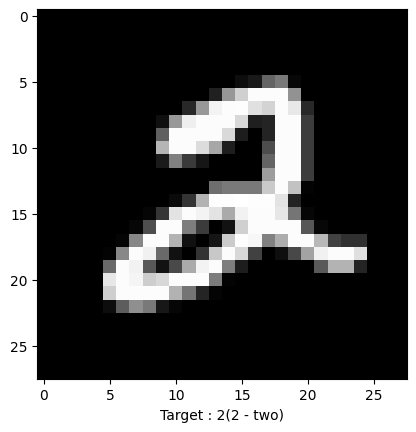

In [8]:
#(2) Display image
show_img(df=mnist_train, index=5)

In [9]:
#(3) Check `input_size`
input_shape = list(mnist_train[0][0].shape)

#(4) Print `input_size`
input_shape

[1, 28, 28]

In [10]:
#(5) Print frequency of target class
target_freq = collections.Counter()
for i in range(len(mnist_train)):
    input, target = mnist_train[i]
    if isinstance(target, torch.Tensor) :
        target = target.item()
    target_freq[target] += 1
pd.DataFrame(data=list(target_freq.items()), columns=['class', 'count']).sort_values(by='class')

,class,count
1,0,5923
3,1,6742
5,2,5958
6,3,6131
2,4,5842
0,5,5421
7,6,5918
8,7,6265
9,8,5851
4,9,5949


#### 01.4. **데이터로더 변환**

In [11]:
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, shuffle=False)
mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=BATCH_SIZE, shuffle=True)

<b></b>

## 02. **모델 구축 및 학습**

#### 02.1. **하이퍼 파라미터 정의**

In [12]:
channel_num = 16

#### 02.1. **모델 정의**

In [ ]:
#(1) Define `model`
model = MyConvAutoEncoder(input_shape=input_shape, channel_num=channel_num, class_num=10, device=device).to(dtype=torch.float32)

#(2) Display `model`
torchinfo.summary(
    model=model, 
    input_size=[BATCH_SIZE]+input_shape,
    device=device
)

Layer (type:depth-idx)                   Output Shape              Param #
MyConvAutoEncoder                        [32, 1, 28, 28]           --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Conv2d: 2-1                       [32, 16, 13, 13]          160
│    └─ReLU: 2-2                         [32, 16, 13, 13]          --
│    └─Conv2d: 2-3                       [32, 32, 6, 6]            4,640
│    └─ReLU: 2-4                         [32, 32, 6, 6]            --
│    └─Conv2d: 2-5                       [32, 64, 4, 4]            18,496
│    └─ReLU: 2-6                         [32, 64, 4, 4]            --
│    └─Flatten: 2-7                      [32, 1024]                --
│    └─Linear: 2-8                       [32, 10]                  10,250
│    └─ReLU: 2-9                         [32, 10]                  --
├─Sequential: 1-2                        [32, 1, 28, 28]           --
│    └─Linear: 2-10                      [32, 1024]                11,264

In [14]:
#(4) Define loss function
criterion = torch.nn.MSELoss()

#(5) Define optimizer(optimization method)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-7)

#(6) Define Scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)

#(7) Define logger
logger = TrainLogger()

#### 02.2. **학습 전 변수 정의**

In [1]:
epoch = 0 
loss_hist = []
best_loss = float('inf')
if USE_CHECKPOINT_YN == 'Y' :
    try :
        checkpoint = torch.load(f=MODEL_PTH, map_location=device)
        model.load_state_dict(state_dict=checkpoint['model'])
        optimizer.load_state_dict(state_dict=checkpoint['optimizer'])
        epoch = checkpoint['best_epoch']
        loss_hist = checkpoint['loss_hist']
        best_loss = loss_hist[-1]
        logger.train_log = torch.load(f=LOGGER_PTH, map_location=device)['train_log']
    except Exception :
        pass
print(f'>> Epoch={epoch}, Best Train Loss={best_loss}')

NameError: name 'USE_CHECKPOINT_YN' is not defined

#### 02.3. **모델 학습**

In [16]:
batch_len = len(mnist_train_loader)
best_epoch = epoch
progress_bar = tqdm.trange(epoch+1, EPOCH_NUM+1)
for epoch in progress_bar : 
    last_loss = 0.0
    model.train()
    for batch_idx, (inputs, targets) in enumerate(iterable=mnist_train_loader) :
        optimizer.zero_grad() 
        preds = model(x=inputs)
        # ---- Not use `targets` ---- #
        loss = criterion(input=preds, target=inputs.to(device=device))
        # ---- _________________ ---- #
        loss.backward()
        optimizer.step()
        last_loss += loss.item()
        # ---- Logging first batch data ---- #
        if batch_idx == 0 : 
            inputs_b_0 = inputs
            preds_b_0 =  preds
        # ---- _______________________ ---- # 
    logger.log(epoch=epoch, inputs=inputs_b_0, preds=preds_b_0, path=LOGGER_PTH)
    
    last_loss_avg = last_loss / batch_len
    loss_hist.append(last_loss_avg)
    if last_loss_avg < best_loss :
        best_epoch = epoch
        best_loss = last_loss_avg
        torch.save(
            obj={
                'model'      : model.state_dict(),
                'optimizer'  : optimizer.state_dict(),
                'best_epoch' : best_epoch,
                'loss_hist'  : loss_hist
            }, 
            f=MODEL_PTH
        )
    # scheduler.step()
    progress_bar.set_postfix(ordered_dict={'last_epoch':epoch, 'last_loss':last_loss_avg, 'best_epoch':best_epoch, 'best_loss':best_loss})

100%|██████████| 100/100 [33:44<00:00, 20.25s/it, last_epoch=100, last_loss=0.0143, best_epoch=100, best_loss=0.0143]


<b></b>

## 03. **모델 평가**

#### 03.1. **최적 성능 모델 로드**

In [17]:
checkpoint = torch.load(f=MODEL_PTH, map_location=device)
model.load_state_dict(state_dict=checkpoint['model'])
print(f'>> Best Epoch : {np.argmin(a=checkpoint["loss_hist"])+1}, Best Loss : {np.min(a=checkpoint["loss_hist"])}')

>> Best Epoch : 100, Best Loss : 0.01428796736051639


#### 04.2. **과소 적합 확인**

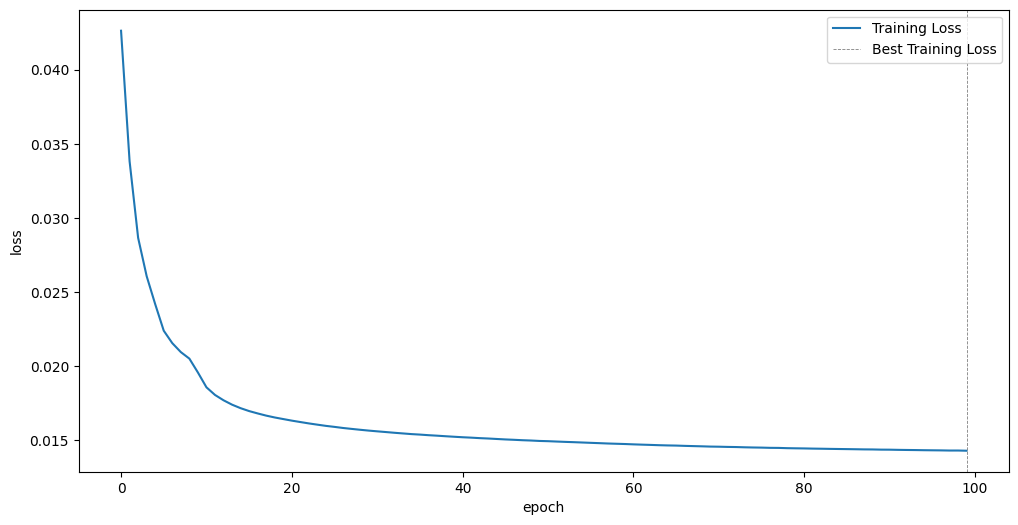

In [18]:
plt.figure(figsize=(12, 6))
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.plot(loss_hist, label='Training Loss')
plt.axvline(x=np.argmin(a=checkpoint["loss_hist"]), color='grey', linestyle='--', linewidth=0.6, label=f'Best Training Loss')
plt.legend(loc='upper right')
plt.show()

#### 03.3. **(에포크 별) 학습 과정 확인**

In [19]:
#(0) Set up interactive mode
%matplotlib widget

#(1) Move device
logger.move_device(device='cpu')

In [20]:
#(2) Define `visualizer`
viz = Visualizer(train_log=logger.train_log, fig_size=(8, 4))

#(3) Set up interactive mode
viz.plot_compare()

#### 03.4. **일반화 성능 확인**

In [21]:
pass